<a href="https://colab.research.google.com/github/kato-taki/optimization-of-cultured-meat-production-system/blob/main/%E2%98%851101_optimization_time_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input

## Import library


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
import time
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import pandas as pd
import random
import statistics
import csv

## Parameter value and Constant value, experimental condition


In [ ]:
# すべてのパラメータをリスト形式で定義
data = [
    #===========================================================================
    # 動物細胞培養工程モジュール (C2C12マウス筋芽細胞)
    #===========================================================================
    # モデルパラメータの初期値および推定値
    # 播種密度
    ["X0_cell",     3.664e7],
    # 培地濃度
    ["Cglc0_cell",  23.2],
    ["Clac0_cell",  8.5887],
    ["Cgln0_cell",  1.4236],
    ["Camm0_cell",  0.83965],
    # 最大比増殖速度
    ["umax_cell",   0.04280950136113015],
    # q = ΔC/ΔX (mmol/cells)
    ["qglc_cell_1", 2.67436e-7],  #1サイクル目
    ["qglc_cell_2", 2.02496e-7],  #2サイクル目以降
    ["qlac_cell_1", 3.95337e-7],  #1サイクル目
    ["qlac_cell_2", 2.99975e-7],  #2サイクル目以降
    ["qgln_cell",   3.898774029384385e-09],
    ["qamm_cell",   1.533722182522993e-09],

    # 動物細胞の変動係数 (CV)
    # 播種密度
    ["CV_X0_cell",  8.648e-2],
    # カウント誤差
    ["CV_X_count",    0.04],
    # 培地濃度
    ["CV_Cglc0_cell", 1.701e-2],
    ["CV_Clac0_cell", 3.366e-2],
    ["CV_Cgln0_cell", 6.962e-2],
    ["CV_Camm0_cell", 0.1042],
    # 最大比増殖速度
    ["CV_umax_cell", 8.104e-2],
    # q = ΔC/ΔX (mmol/cells)
    ["CV_qglc_cell", 8.041e-2],
    ["CV_qlac_cell", 6.476e-2],
    ["CV_qgln_cell", 9.956e-2],
    ["CV_qamm_cell", 0.1323],


    #===========================================================================
    # 藻類培養工程モジュール (synechococcus sp.)
    #===========================================================================
    # モデルパラメータの初期値および推定値
    # 播種密度
    ["X0_algae", 4.667e10],
    #培地濃度
    ["Cglc0_algae", 18.6505],
    ["Clac0_algae", 34.70],
    ["Cgln0_algae", 1.4236],
    ["Camm0_algae", 2.94],
    # 最大比増殖速度
    ["umax_algae", 0.002753245657083259],
    # q = ΔC/ΔX (mmol/cells)
    ["qglc_algae", 1.21806e-11],
    ["qlac_algae", 1.85181e-9],
    ["qgln_algae", -4.194886042546756e-12],
    ["qamm_algae", 1.3534202942687656e-10],

    # 藻類の変動係数 (CV)
    # 播種密度
    ["CV_X0_algae", 1.101e-2],
    # 培地濃度
    ["CV_Cglc0_algae", 0.2072],
    ["CV_Clac0_algae", 4.389e-3],
    ["CV_Cgln0_algae", 0.1282],
    ["CV_Camm0_algae", 8.478e-2],
    # 最大比増殖速度
    ["CV_umax_algae", 0.1597],
    # # q = ΔC/ΔX (mmol/cells)
    ["CV_qglc_algae", 2.4162],
    ["CV_qlac_algae", 0.2372],
    ["CV_qgln_algae", 1.192],
    ["CV_qamm_algae", 0.1778],


    #===========================================================================
    # 藻類栄養素抽出工程モジュール
    #===========================================================================
    # C2C12細胞・乳酸資化シネココッカス循環培養より推定
    ["kglc", 2.13e-9],    #7.7075099320995e-10
    ["CV_kglc", 0.207],  #0.0993444775580169


    #===========================================================================
    # 培養操作パラメータ
    #===========================================================================
    # 抽出した栄養素を藻類廃培地に添加する割合
    ["k_hydrolysis", 5/100],
    # 動物細胞培養タンクの容積
    ["V", 1],
    # 藻類培養タンクと動物細胞培養タンクの容積比率
    ["k_vol", 4.97098669969603],
    # 培地抜き出し率
    ["r", 0.492689325369242],
    # 1サイクルの培養期間
    ["t_cycle", 36],


    #===========================================================================
    # 定数および実験条件
    #===========================================================================
    # 飽和定数KS
    ["Kglc", 1.7798238103747508],
    ["Kgln", 0.1],
    ["Kamm_algae", 0.03569506712587975],

    # 阻害定数KI
    ["Klac_cell", 50.15303470159003],
    ["Kamm_cell", 8.0],

    # グルタミン分解定数
    ["kd_gln_37", 3.6505e-3],
    ["kd_gln_25", 1.2038e-3],

    # 実験条件
    # トータルの培養期間
    ["t_tot", 480],
    # シミュレーション実行回数
    ["scale", 100]
]

# グローバル変数に各パラメータを設定
for item in data:
    globals()[item[0]] = item[1]

# CSVファイルに書き込む
output_file = 'model_parameters_with_sd_cv.csv'
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Parameter", "Value"])  # ヘッダー行の書き込み
    writer.writerows(data)  # パラメータと値を行として書き込む

print(f"Model parameters have been written to {output_file}")

# サイクル数
cycle_num = int(t_tot / t_cycle)

Model parameters have been written to model_parameters_with_sd_cv.csv


# Process

## Definition of culture process function

In [ ]:
# dt を適切に定義
dt = 0.05  # タイムステップの値

#===============================================================================
#動物細胞培養工程モジュール
#===============================================================================
#1サイクル目
def cell_culture_1(t, y):
    X,Cglc,Clac,Cgln,Camm = y
    #比増殖速度
    u = umax_cell *(Cglc/((Kglc+Cglc)*(1+Clac/Klac_cell)))*(Cgln/((Kgln+Cgln)*(1+Camm/Kamm_cell)))
    #増殖速度式
    dXdt = u * X

    #代謝速度式
    #グルコース代謝
    dCglcdt = -qglc_cell_1 * u * X
    # Cglcが負の値をとらないようにする制約
    if Cglc + dCglcdt * dt < 0:   # ここで dt は時間の微小な変化量（タイムステップ）を表す
      dCglcdt = -Cglc / dt        # dt で割ることでタイムステップに基づいて調整

    #乳酸代謝
    dClacdt = qlac_cell_1 * u * X

    #グルタミン代謝
    dCglndt = -qgln_cell * u * X - kd_gln_37 * Cgln
    # Cglnが負の値をとらないようにする制約
    if Cgln + dCglndt * dt < 0:
      dCglndt = -Cgln / dt

    #アンモニア代謝
    dCammdt = qamm_cell * u * X + kd_gln_37 * Cgln

    return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]

#2サイクル目以降
def cell_culture_2(t, y):
    X,Cglc,Clac,Cgln,Camm = y
    #比増殖速度
    u = umax_cell *(Cglc/((Kglc+Cglc)*(1+Clac/Klac_cell)))*(Cgln/((Kgln+Cgln)*(1+Camm/Kamm_cell)))
    #増殖速度式
    dXdt = u * X

    #代謝速度式
    #グルコース代謝
    dCglcdt = -qglc_cell_2 * u * X
    # Cglcが負の値をとらないようにする制約
    if Cglc + dCglcdt * dt < 0:
      dCglcdt = -Cglc / dt

    #乳酸代謝
    dClacdt = qlac_cell_2 * u * X

    #グルタミン代謝
    dCglndt = -qgln_cell * u * X - kd_gln_37 * Cgln
    # Cglnが負の値をとらないようにする制約
    if Cgln + dCglndt * dt < 0:
      dCglndt = -Cgln / dt

    #アンモニア代謝
    dCammdt = qamm_cell * u * X + kd_gln_37 * Cgln

    return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]


#動物細胞の比増殖速度
def u_cell(Cglc, Clac, Cgln, Camm):
  u = umax_cell *(Cglc/((Kglc+Cglc)*(1+Clac/Klac_cell)))*(Cgln/((Kgln+Cgln)*(1+Camm/Kamm_cell)))
  return u

#===============================================================================
#藻類培養工程モジュール
#===============================================================================
def algae_culture(t, y):
  X,Cglc,Clac,Cgln,Camm = y
  #比増殖速度
  u = umax_algae *(Camm/(Kamm_algae+Camm))
  #増殖速度式
  dXdt = u * X

  #代謝速度式
  #グルコース代謝
  dCglcdt = -qglc_algae * u * X
  # Cglcが負の値をとらないようにする制約
  if Cglc + dCglcdt * dt < 0:
    dCglcdt = -Cglc / dt

  #乳酸代謝
  dClacdt = -qlac_algae * u * X
  # Clacが負の値をとらないようにする制約
  if Clac + dClacdt * dt < 0:
    dClacdt = -Clac / dt

  #グルタミン代謝
  dCglndt = -qgln_algae * u * X - kd_gln_25 * Cgln

  #アンモニア代謝
  dCammdt = -qamm_algae * u * X + kd_gln_25 * Cgln
  # Cammが負の値をとらないようにする制約
  if Camm + dCammdt * dt < 0:
    dCammdt = -Camm / dt


  return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]


#藻類の比増殖速度
def u_algae(Camm):
  u = umax_algae *(Camm/(Kamm_algae+Camm))
  return u


#===============================================================================
#培地交換プロセス
#===============================================================================
#動物細胞培地
def exchange_cell(C_cell,C_algae,list_C,r):
  C = (1-r)*C_cell[-1] + r*C_algae[-1]  #培地交換後の濃度
  list_C.append(C)
  return list_C

#藻類培地
def exchange_algae(C_cell,C_algae,list_C,k_vol,r):
  C = ((k_vol - r)*C_algae[-1] + r*C_cell[-1])/k_vol  #培地交換後の濃度
  list_C.append(C)
  return list_C


#===============================================================================
#経時変化を出力する関数
#===============================================================================
#配列を初期化する関数
def initialize_array(array_list, shape=(2,)):
    return np.zeros((shape[0], len(array_list[-1])))

#リストから平均値を計算する関数
def calculate_mean(values_list, scale, i):
    return statistics.mean(values_list[j][i] for j in range(scale))

#リストから変動係数を計算する関数
def calculate_cv(values_list, mean_value, scale, i):
    if mean_value == 0:
        return 0  # 平均値がゼロの場合、CVをゼロに設定
    return statistics.stdev(values_list[j][i] for j in range(scale)) / mean_value

## Definition of CCC model

In [ ]:
##4. CCCモデルの定義．
def CCC_model(
    umax_cell,
    qglc_cell_1,
    qglc_cell_2,
    qlac_cell_1,
    qlac_cell_2,
    qgln_cell,
    qamm_cell,
    umax_algae,
    qglc_algae,
    qlac_algae,
    qgln_algae,
    qamm_algae,
    kglc
):

  #=============================================================================
  #CCCモデルパラメータの初期値
  #=============================================================================
  #入力パラメータの乱数生成
  #入力パラメータと標準偏差の対応をまとめる
  param_rand = {
      'list_umax_cell':   (umax_cell,   umax_cell*CV_umax_cell),
      'list_umax_algae':  (umax_algae, umax_algae*CV_umax_algae),
      'list_qglc_cell_1': (qglc_cell_1,   qglc_cell_1*CV_qglc_cell),
      'list_qglc_cell_2': (qglc_cell_2,   qglc_cell_2*CV_qglc_cell),
      'list_qlac_cell_1': (qlac_cell_1,   qlac_cell_1*CV_qlac_cell),
      'list_qlac_cell_2': (qlac_cell_2,   qlac_cell_2*CV_qlac_cell),
      'list_qgln_cell':   (qgln_cell,   qgln_cell*CV_qgln_cell),
      'list_qamm_cell':   (qamm_cell,   qamm_cell*CV_qamm_cell),
      'list_qglc_algae':  (qglc_algae, qglc_algae*CV_qglc_algae),
      'list_qlac_algae':  (qlac_algae, qlac_algae*CV_qlac_algae),
      'list_qgln_algae':  (qgln_algae, qgln_algae*CV_qgln_algae),
      'list_qamm_algae':  (qamm_algae, qamm_algae*CV_qamm_algae),
      'list_kglc':        (kglc, kglc*CV_kglc)
  }

  # 乱数生成をまとめて実行
  globals().update({
      name: [random.gauss(param, sd) for i in range(scale)]
      for name, (param, sd) in param_rand.items()
  })


  # モデルパラメータの経時変化を格納するリスト
  list_names = [
      # 動物細胞培養工程モジュールのパラメータ
      'list_X_cell', 'list_u_cell', 'list_Cglc_cell', 'list_Clac_cell',
      'list_Cgln_cell', 'list_Camm_cell',
      # 藻類培養工程モジュールのパラメータ
      'list_X_algae', 'list_u_algae', 'list_Cglc_algae', 'list_Clac_algae',
      'list_Cgln_algae', 'list_Camm_algae',
      # 培地交換後の濃度（動物細胞培養工程）
      'list_Cglc_cell_i', 'list_Clac_cell_i', 'list_Cgln_cell_i', 'list_Camm_cell_i',
      # 培地交換後の濃度（藻類培養工程）
      'list_Cglc_algae_i', 'list_Clac_algae_i', 'list_Cgln_algae_i', 'list_Camm_algae_i',
      # 回収細胞密度
      'list_N'
  ]

  # リストをまとめて初期化
  globals().update({name: [[] for i in range(scale)] for name in list_names})

  #培養時間
  list_time = []


  #=============================================================================
  #CCCモデルの実行
  #=============================================================================
  for n in range(scale):
    # フラグ管理
    if n == 0:
      flag = True
    else:
      flag = False
    #培養時間
    time = 0
    #乱数データから入力値を設定する
    umax_cell   =  list_umax_cell[n]
    umax_algae  =  list_umax_algae[n]
    qglc_cell_1 =  list_qglc_cell_1[n]
    qglc_cell_2 =  list_qglc_cell_2[n]
    qlac_cell_1 =  list_qlac_cell_1[n]
    qlac_cell_2 =  list_qlac_cell_2[n]
    qgln_cell   =  list_qgln_cell[n]
    qamm_cell   =  list_qamm_cell[n]
    qglc_algae  =  list_qglc_algae[n]
    qlac_algae  =  list_qlac_algae[n]
    qgln_algae  =  list_qgln_algae[n]
    qamm_algae  =  list_qamm_algae[n]
    kglc        =  list_kglc[n]


    for i in range(cycle_num):
      #===========================================================================
      #動物細胞培養プロセスの初期設定
      #===========================================================================
      # 1サイクル目の初期細胞密度と培地濃度の初期値の定義．
      if i == 0:
        #初期細胞密度
        X0    = random.gauss(X0_cell,X0_cell*CV_X0_cell)
        #培地濃度の初期値
        Cglc0 = random.gauss(Cglc0_cell,Cglc0_cell*CV_Cglc0_cell)
        Clac0 = random.gauss(Clac0_cell,Clac0_cell*CV_Clac0_cell)
        Cgln0 = random.gauss(Cgln0_cell,Cgln0_cell*CV_Cgln0_cell)
        Camm0 = random.gauss(Camm0_cell,Camm0_cell*CV_Camm0_cell)
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]
      # 2サイクル目以降の初期細胞密度と培地濃度の初期値の定義．
      else:
        #初期細胞密度(セルカウントのCVを考慮する必要がある)
        X0    = random.gauss(list_X_cell[n][-1],list_X_cell[n][-1]*CV_X_count)
        #培地濃度
        Cglc0 = list_Cglc_cell_i[n][-1]
        Clac0 = list_Clac_cell_i[n][-1]
        Cgln0 = list_Cgln_cell_i[n][-1]
        Camm0 = list_Camm_cell_i[n][-1]
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #===========================================================================
      #動物細胞培養プロセスの実行
      #===========================================================================
      # 培養期間の定義
      t_span = (0, t_cycle)  # 時間範囲
      t_eval = np.linspace(*t_span, int(1000*t_cycle/48))  # 評価する時間点
      # 動物細胞培養プロセスの計算
      if i == 0:  # 1サイクル目
        cell_culture = cell_culture_1
      elif list_Cglc_cell_i[n][-1] > 10:  # Cglc > 10 mmol/Lのとき
        cell_culture = cell_culture_1
      else:
        cell_culture = cell_culture_2

      sol = solve_ivp(cell_culture, t_span, y0, t_eval=t_eval)

      #リストに動物細胞培養の経時変化を格納する
      list_X_cell[n].extend(sol.y[0])
      list_Cglc_cell[n].extend(sol.y[1])
      list_Clac_cell[n].extend(sol.y[2])
      list_Cgln_cell[n].extend(sol.y[3])
      list_Camm_cell[n].extend(sol.y[4])

      #比増殖速度データの生成
      for x in range(len(sol.t)):
        list_u_cell[n].append(u_cell(sol.y[1][x],sol.y[2][x],sol.y[3][x],sol.y[4][x]))


      #===========================================================================
      #動物細胞抜き出し操作
      #===========================================================================
      # 回収細胞密度
      list_N[n].append(list_X_cell[n][-1] * r * V)
      # 抜き出し後の細胞密度
      list_X_cell[n][-1] = (1-r) * list_X_cell[n][-1]


      #===========================================================================
      #藻類培養プロセスの初期設定
      #===========================================================================
      # 1サイクル目の初期細胞密度の定義．
      if i == 0:
        #初期細胞密度
        X0    = random.gauss(X0_algae,X0_algae*CV_X0_algae)
        #培地濃度の初期値
        Cglc0 = random.gauss(Cglc0_algae,Cglc0_algae*CV_Cglc0_algae)
        Clac0 = random.gauss(Clac0_algae,Clac0_algae*CV_Clac0_algae)
        Cgln0 = random.gauss(Cgln0_algae,Cgln0_algae*CV_Cgln0_algae)
        Camm0 = random.gauss(Camm0_algae,Camm0_algae*CV_Camm0_algae)
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]
      # 2サイクル目以降の初期細胞密度と培地濃度の初期値の定義．
      else:
        #初期細胞密度(セルカウントのCVを考慮する必要がある)
        X0 = random.gauss(list_X_algae[n][-1],list_X_algae[n][-1]*CV_X_count)
        #培地濃度
        Cglc0 = list_Cglc_algae_i[n][-1]
        Clac0 = list_Clac_algae_i[n][-1]
        Cgln0 = list_Cgln_algae_i[n][-1]
        Camm0 = list_Camm_algae_i[n][-1]
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #===========================================================================
      #5. 藻類培養プロセスの実行
      #===========================================================================
      #藻類培養プロセスの計算
      sol = solve_ivp(algae_culture, t_span, y0, t_eval=t_eval)

      #リストに藻類培養の経時変化を格納する
      list_X_algae[n].extend(sol.y[0])
      list_Cglc_algae[n].extend(sol.y[1])
      list_Clac_algae[n].extend(sol.y[2])
      list_Cgln_algae[n].extend(sol.y[3])
      list_Camm_algae[n].extend(sol.y[4])

      #比増殖速度データの生成
      for x in range(len(sol.t)):
        list_u_algae[n].append(u_algae(sol.y[4][x]))

      #培養時間をプロセス時間に変換し格納する
      if flag == True:
        for j in range(len(sol.t)):
          sol.t[j] = sol.t[j] + time
        list_time.extend(sol.t)
        #プロセス時間の更新
        time += t_cycle


      #===========================================================================
      #藻類栄養素抽出プロセス，藻類抜き出し操作
      #===========================================================================
      #酸加水分解反応（藻類培地にグルコースを添加）
      list_Cglc_algae[n][-1]  = list_Cglc_algae[n][-1] + r*(k_hydrolysis*kglc*list_X_algae[n][-1])/k_vol
      #抜き出し後の細胞密度
      list_X_algae[n][-1] = ((k_vol - r) * list_X_algae[n][-1])/k_vol


      #===========================================================================
      #培地交換操作
      #===========================================================================
      # 培地交換操作後の培地濃度
      # 動物細胞培地
      exchange_cell(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_cell_i[n],r)
      exchange_cell(list_Clac_cell[n],list_Clac_algae[n],list_Clac_cell_i[n],r)
      exchange_cell(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_cell_i[n],r)
      exchange_cell(list_Camm_cell[n],list_Camm_algae[n],list_Camm_cell_i[n],r)

      # 藻類培地
      exchange_algae(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_algae_i[n],k_vol,r)
      exchange_algae(list_Clac_cell[n],list_Clac_algae[n],list_Clac_algae_i[n],k_vol,r)
      exchange_algae(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_algae_i[n],k_vol,r)
      exchange_algae(list_Camm_cell[n],list_Camm_algae[n],list_Camm_algae_i[n],k_vol,r)


    #===========================================================================
    #培養期間Δtが480時間の約数でない場合，残り時間のプロセスを実行
    #===========================================================================
    if t_tot - t_cycle * cycle_num > 0:

      #=========================================================================
      #動物細胞培養プロセスの初期設定
      #=========================================================================
      # 初期細胞密度と培地濃度の初期値の定義．
      # 初期細胞密度(セルカウントのCVを考慮する必要がある)
      X0    = random.gauss(list_X_cell[n][-1],list_X_cell[n][-1]*CV_X_count)
      # 培地濃度
      Cglc0 = list_Cglc_cell_i[n][-1]
      Clac0 = list_Clac_cell_i[n][-1]
      Cgln0 = list_Cgln_cell_i[n][-1]
      Camm0 = list_Camm_cell_i[n][-1]
      y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #=========================================================================
      #動物細胞培養プロセスの実行
      #=========================================================================
      # 培養期間の定義
      t_span = (0, t_tot - t_cycle * cycle_num)  # 時間範囲
      t_eval = np.linspace(*t_span, int(1000*(t_tot - t_cycle * cycle_num)/48))  # 評価する時間点
      # 動物細胞培養プロセスの計算
      if list_Cglc_cell_i[n][-1] > 10:  # Cglc > 10 mmol/Lのとき
        cell_culture = cell_culture_1
      else:
        cell_culture = cell_culture_2

      sol = solve_ivp(cell_culture, t_span, y0, t_eval=t_eval)

      #リストに動物細胞培養の経時変化を格納する
      list_X_cell[n].extend(sol.y[0])
      list_Cglc_cell[n].extend(sol.y[1])
      list_Clac_cell[n].extend(sol.y[2])
      list_Cgln_cell[n].extend(sol.y[3])
      list_Camm_cell[n].extend(sol.y[4])

      #比増殖速度データの生成
      for x in range(len(sol.t)):
        list_u_cell[n].append(u_cell(sol.y[1][x],sol.y[2][x],sol.y[3][x],sol.y[4][x]))


      #=========================================================================
      #動物細胞抜き出し操作
      #=========================================================================
      # 回収細胞密度
      list_N[n].append(list_X_cell[n][-1] * r * V)
      # 抜き出し後の細胞密度
      list_X_cell[n][-1] = (1-r) * list_X_cell[n][-1]


      #=========================================================================
      #藻類培養プロセスの初期設定
      #=========================================================================
      # 初期細胞密度と培地濃度の初期値の定義．
      # 初期細胞密度(セルカウントのCVを考慮する必要がある)
      X0 = random.gauss(list_X_algae[n][-1],list_X_algae[n][-1]*CV_X_count)
      # 培地濃度
      Cglc0 = list_Cglc_algae_i[n][-1]
      Clac0 = list_Clac_algae_i[n][-1]
      Cgln0 = list_Cgln_algae_i[n][-1]
      Camm0 = list_Camm_algae_i[n][-1]
      y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #=========================================================================
      #5. 藻類培養プロセスの実行
      #=========================================================================
      #藻類培養プロセスの計算
      sol = solve_ivp(algae_culture, t_span, y0, t_eval=t_eval)

      #リストに藻類培養の経時変化を格納する
      list_X_algae[n].extend(sol.y[0])
      list_Cglc_algae[n].extend(sol.y[1])
      list_Clac_algae[n].extend(sol.y[2])
      list_Cgln_algae[n].extend(sol.y[3])
      list_Camm_algae[n].extend(sol.y[4])

      #比増殖速度データの生成
      for x in range(len(sol.t)):
        list_u_algae[n].append(u_algae(sol.y[4][x]))

      #培養時間をプロセス時間に変換し格納する
      if flag == True:
        for j in range(len(sol.t)):
          sol.t[j] = sol.t[j] + time
        list_time.extend(sol.t)
        #プロセス時間の更新
        time += t_cycle


      #=========================================================================
      #藻類栄養素抽出プロセス，藻類抜き出し操作
      #=========================================================================
      #酸加水分解反応（藻類培地にグルコースを添加）
      list_Cglc_algae[n][-1]  = list_Cglc_algae[n][-1] + r*(k_hydrolysis*kglc*list_X_algae[n][-1])/k_vol
      #抜き出し後の細胞密度
      list_X_algae[n][-1] = ((k_vol - r) * list_X_algae[n][-1])/k_vol


      #=========================================================================
      #培地交換操作
      #=========================================================================
      # 培地交換操作後の培地濃度
      # 動物細胞培地
      exchange_cell(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_cell_i[n],r)
      exchange_cell(list_Clac_cell[n],list_Clac_algae[n],list_Clac_cell_i[n],r)
      exchange_cell(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_cell_i[n],r)
      exchange_cell(list_Camm_cell[n],list_Camm_algae[n],list_Camm_cell_i[n],r)

      # 藻類培地
      exchange_algae(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_algae_i[n],k_vol,r)
      exchange_algae(list_Clac_cell[n],list_Clac_algae[n],list_Clac_algae_i[n],k_vol,r)
      exchange_algae(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_algae_i[n],k_vol,r)
      exchange_algae(list_Camm_cell[n],list_Camm_algae[n],list_Camm_algae_i[n],k_vol,r)

  # t = 480 hにおける回収細胞密度の変動係数を確認
  Y_CV = statistics.stdev(list_N[i][-1] for i in range(scale))/statistics.mean(list_N[i][-1] for i in range(scale))
  print(Y_CV)

  return (
    # 培養時間と動物細胞関連のリスト
    list_time, list_X_cell, list_u_cell, list_Cglc_cell,
    list_Clac_cell, list_Cgln_cell, list_Camm_cell,

    # 藻類関連のリスト
    list_X_algae, list_u_algae, list_Cglc_algae,
    list_Clac_algae, list_Cgln_algae, list_Camm_algae,

    # 回収細胞密度
    list_N
  )

# Output

## Outputs of model parameters

In [ ]:
#===============================================================================
#モデルの出力
#===============================================================================
#経時変化の出力
#CCC_model関数を呼び出し、戻り値を変数に代入する
list_time, \
list_X_cell, list_u_cell, list_Cglc_cell, list_Clac_cell, list_Cgln_cell, list_Camm_cell, \
list_X_algae, list_u_algae, list_Cglc_algae, list_Clac_algae, list_Cgln_algae, list_Camm_algae, \
list_N = CCC_model(
    umax_cell, qglc_cell_1, qglc_cell_2, qlac_cell_1, qlac_cell_2, qgln_cell, qamm_cell,
    umax_algae, qglc_algae, qlac_algae, qgln_algae, qamm_algae, kglc
)


#平均値，CVの出力
# 配列の初期化（initialize_array関数を使って初期化する）
X_cell_array      = initialize_array(list_X_cell)       # 動物細胞密度
u_cell_array      = initialize_array(list_u_cell)       # 比増殖速度
Cglc_cell_array   = initialize_array(list_Cglc_cell)    # グルコース濃度
Clac_cell_array   = initialize_array(list_Clac_cell)    # 乳酸濃度
Cgln_cell_array   = initialize_array(list_Cgln_cell)    # グルタミン濃度
Camm_cell_array   = initialize_array(list_Camm_cell)    # アンモニア濃度

X_algae_array     = initialize_array(list_X_algae)      # 藻類細胞密度
u_algae_array     = initialize_array(list_u_algae)      # 比増殖速度
Cglc_algae_array  = initialize_array(list_Cglc_algae)   # グルコース濃度
Clac_algae_array  = initialize_array(list_Clac_algae)   # 乳酸濃度
Cgln_algae_array  = initialize_array(list_Cgln_algae)   # グルタミン濃度
Camm_algae_array  = initialize_array(list_Camm_algae)   # アンモニア濃度

N_array = initialize_array(list_N)                       # 回収細胞密度

# モデルパラメータのリストと配列の対応を辞書にまとめる
param_dict = {
    'X_cell': (list_X_cell, X_cell_array),
    'u_cell': (list_u_cell, u_cell_array),
    'Cglc_cell': (list_Cglc_cell, Cglc_cell_array),
    'Clac_cell': (list_Clac_cell, Clac_cell_array),
    'Cgln_cell': (list_Cgln_cell, Cgln_cell_array),
    'Camm_cell': (list_Camm_cell, Camm_cell_array),
    'X_algae': (list_X_algae, X_algae_array),
    'u_algae': (list_u_algae, u_algae_array),
    'Cglc_algae': (list_Cglc_algae, Cglc_algae_array),
    'Clac_algae': (list_Clac_algae, Clac_algae_array),
    'Cgln_algae': (list_Cgln_algae, Cgln_algae_array),
    'Camm_algae': (list_Camm_algae, Camm_algae_array)
}

# 各リストに対して平均値と変動係数を計算
for i in range(len(list_time)):
    for key, (param_list, param_array) in param_dict.items():
        # 平均値の計算
        param_array[0][i] = calculate_mean(param_list, scale, i)
        # 変動係数の計算
        param_array[1][i] = calculate_cv(param_list, param_array[0][i], scale, i)

# 回収細胞密度の平均値および変動係数の計算
for i in range(len(N_array[0])):
    N_array[0][i] = calculate_mean(list_N, scale, i)
    N_array[1][i] = calculate_cv(list_N, N_array[0][i], scale, i)

0.17653859467584454


## Time profile

In [ ]:
# 共通のCSV書き込み関数
def write_csv(filename, header, list_time, list_data, scale):
    with open(filename, "w") as f:
        f.write(header + "\n")
        for i in range(len(list_time)):
            values = ",".join([str(list_data[j][i]) for j in range(scale)])
            f.write(f"{list_time[i]},{values}\n")

# 各データセットと対応するファイル名、ヘッダー情報
datasets = [
    ("./optimize_cell_density_animal_cell.csv", "t,X", list_X_cell),
    ("./optimize_cell_density_algae.csv", "t,X", list_X_algae),
    ("./optimize_specific_growth_rate_animal_cell.csv", "t,u", list_u_cell),
    ("./optimize_specific_growth_rate_algae.csv", "t,u", list_u_algae),
    ("./optimize_glucose_animal_cell.csv", "t,Cglc", list_Cglc_cell),
    ("./optimize_glucose_algae.csv", "t,Cglc", list_Cglc_algae),
    ("./optimize_lacate_animal_cell.csv", "t,Clac", list_Clac_cell),
    ("./optimize_lacate_algae.csv", "t,Clac", list_Clac_algae),
    ("./optimize_glutamine_animal_cell.csv", "t,Cgln", list_Cgln_cell),
    ("./optimize_glutamine_algae.csv", "t,Cgln", list_Cgln_algae),
    ("./optimize_ammonia_animal_cell.csv", "t,Camm", list_Camm_cell),
    ("./optimize_ammonia_algae.csv", "t,Camm", list_Camm_algae)
]

# データ書き込みのループ
for filename, header, list_data in datasets:
    write_csv(filename, header, list_time, list_data, scale)

# Harvested cell density (N) の場合は異なるリストとループ
def write_harvested_csv(filename, header, list_data, cycle_num, t_cycle, scale):
    with open(filename, "w") as f:
        f.write(header + "\n")
        for i in range(cycle_num):
            values = ",".join([str(list_data[j][i]) for j in range(scale)])
            f.write(f"{(i+1)*t_cycle},{values}\n")

# Harvested cell density
write_harvested_csv("./optimize_harvested_cell_density.csv", "t,N (cells/L)", list_N, cycle_num, t_cycle, scale)

## Time profile (mean, CV)

In [ ]:
# 共通のCSV書き込み関数
def write_mean_cv_csv(filename, header, list_time, data_arrays):
    with open(filename, "w") as f:
        f.write(header + "\n")
        for i in range(len(list_time)):
            values = ",".join([str(data_arrays[j][i]) for j in range(len(data_arrays))])
            f.write(f"{list_time[i]},{values}\n")

# 1. Cell density (動物細胞と藻類)
write_mean_cv_csv(
    "./optimize_mean_CV_cell_density.csv",
    "t,X_cell,CV,X_algae,CV",
    list_time,
    [X_cell_array[0], X_cell_array[1], X_algae_array[0], X_algae_array[1]]
)

# 2. Specific growth rate (動物細胞と藻類)
write_mean_cv_csv(
    "./optimize_mean_CV_specific_growth_rate.csv",
    "t,u_cell,CV,u_algae,CV",
    list_time,
    [u_cell_array[0], u_cell_array[1], u_algae_array[0], u_algae_array[1]]
)

# 3. Medium concentration for animal cells (glucose, lactate, glutamine, ammonia)
write_mean_cv_csv(
    "./optimize_mean_CV_medium_cell.csv",
    "t,Cglc,CV,Clac,CV,Cgln,CV,Camm,CV",
    list_time,
    [Cglc_cell_array[0], Cglc_cell_array[1], Clac_cell_array[0], Clac_cell_array[1],
     Cgln_cell_array[0], Cgln_cell_array[1], Camm_cell_array[0], Camm_cell_array[1]]
)

# 4. Medium concentration for algae (glucose, lactate, glutamine, ammonia)
write_mean_cv_csv(
    "./optimize_mean_CV_medium_algae.csv",
    "t,Cglc,CV,Clac,CV,Cgln,CV,Camm,CV",
    list_time,
    [Cglc_algae_array[0], Cglc_algae_array[1], Clac_algae_array[0], Clac_algae_array[1],
     Cgln_algae_array[0], Cgln_algae_array[1], Camm_algae_array[0], Camm_algae_array[1]]
)

# 5. Harvested cell density (N)
def write_harvested_mean_cv_csv(filename, header, data_array):
    with open(filename, "w") as f:
        f.write(header + "\n")
        for i in range(len(data_array[0])):
            f.write(f"{i},{data_array[0][i]},{data_array[1][i]}\n")

write_harvested_mean_cv_csv(
    "./optimize_mean_CV_harvested_cell_density.csv",
    "cycle,N,CV",
    N_array
)

## Graphs

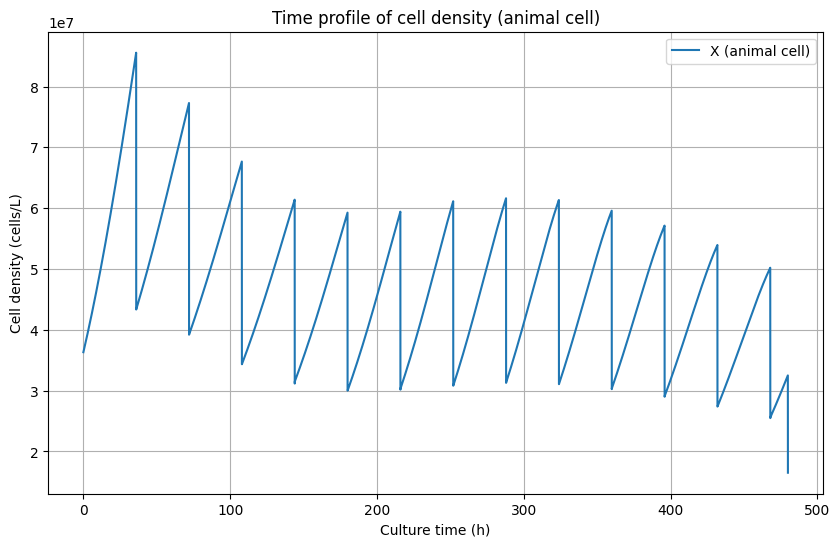

In [ ]:
#結果のプロット
#1. 動物細胞密度
plt.figure(figsize=(10, 6))
plt.plot(list_time, X_cell_array[0], label='X (animal cell)')
plt.xlabel('Culture time (h)')
plt.ylabel('Cell density (cells/L)')
plt.legend()
plt.title('Time profile of cell density (animal cell)')
plt.grid()
plt.show()

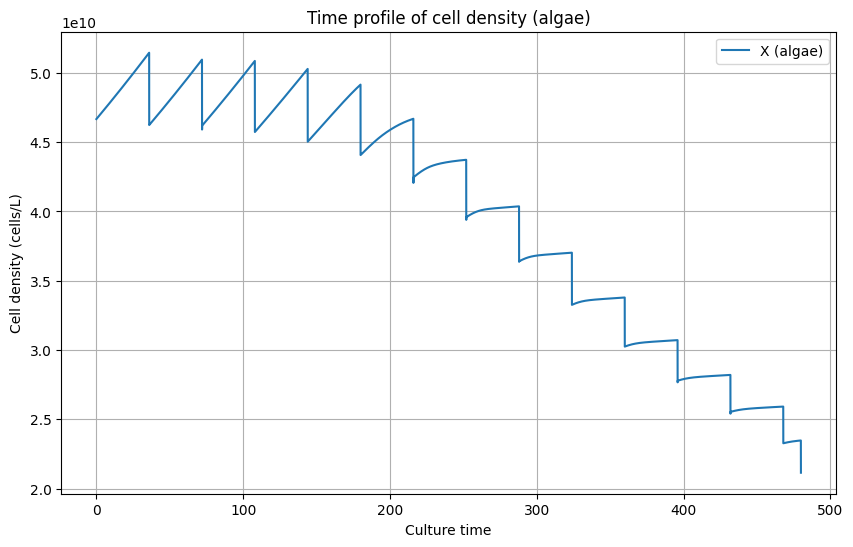

In [ ]:
#結果のプロット
#2. 藻類密度
plt.figure(figsize=(10, 6))
plt.plot(list_time, X_algae_array[0], label='X (algae)')
plt.xlabel('Culture time')
plt.ylabel('Cell density (cells/L)')
plt.legend()
plt.title('Time profile of cell density (algae)')
plt.grid()
plt.show()

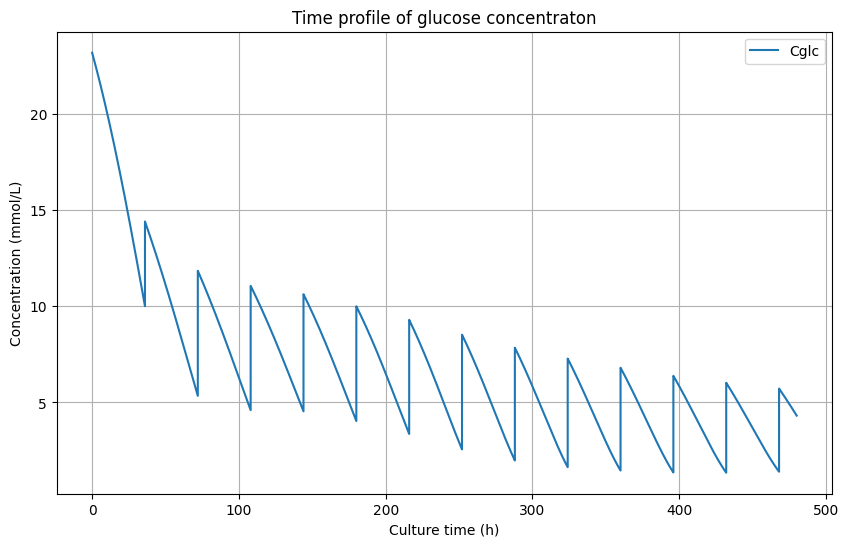

In [ ]:
#結果のプロット
#3. グルコース
plt.figure(figsize=(10, 6))
plt.plot(list_time, Cglc_cell_array[0], label='Cglc')
plt.xlabel('Culture time (h)')
plt.ylabel('Concentration (mmol/L)')
plt.legend()
plt.title('Time profile of glucose concentraton')
plt.grid()
plt.show()

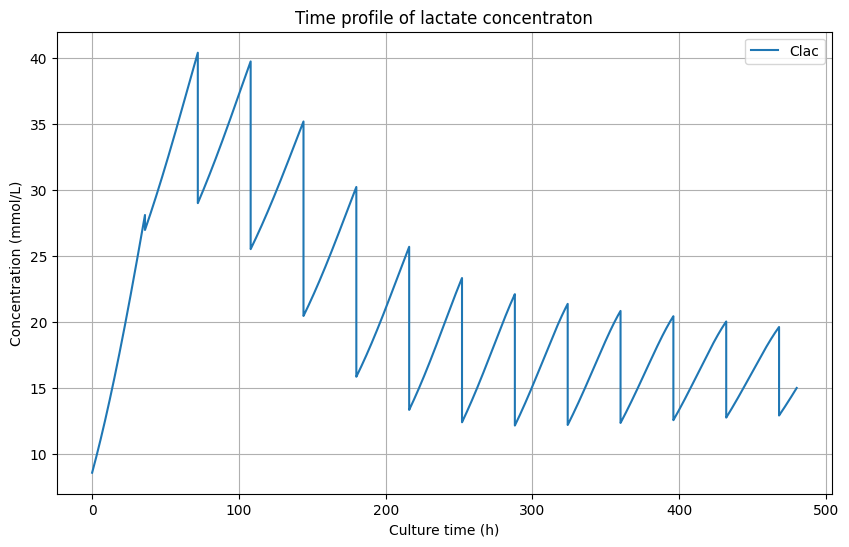

In [ ]:
#結果のプロット
#4. 乳酸
plt.figure(figsize=(10, 6))
plt.plot(list_time, Clac_cell_array[0], label='Clac')
plt.xlabel('Culture time (h)')
plt.ylabel('Concentration (mmol/L)')
plt.legend()
plt.title('Time profile of lactate concentraton')
plt.grid()
plt.show()

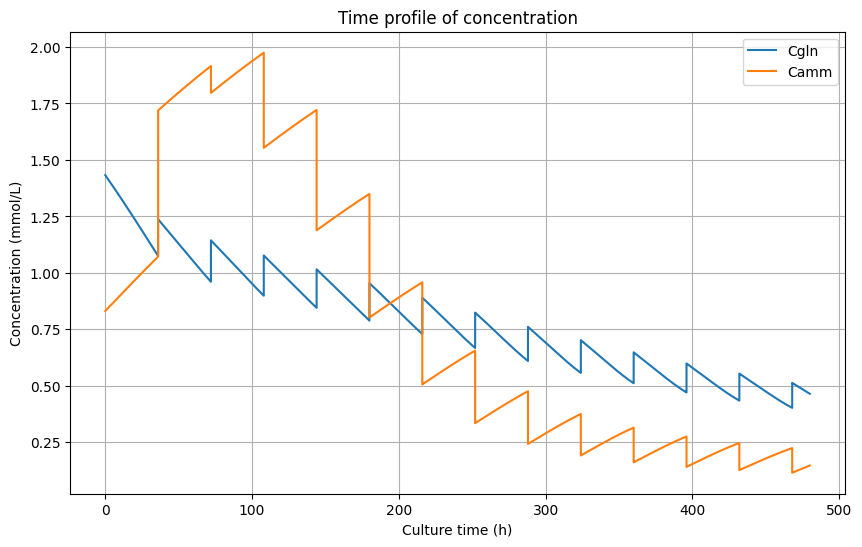

In [ ]:
#結果のプロット
#5. グルタミン，アンモニア濃度
plt.figure(figsize=(10, 6))
plt.plot(list_time, Cgln_cell_array[0], label='Cgln')
plt.plot(list_time, Camm_cell_array[0], label='Camm')
plt.xlabel('Culture time (h)')
plt.ylabel('Concentration (mmol/L)')
plt.legend()
plt.title('Time profile of concentration')
plt.grid()
plt.show()